In [ ]:
#| default_exp viz

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| include: false
# Do this on Colab and then restart runtime:
#!pip install fastai --upgrade | grep -v 'already satisfied'
#!pip install git+https://github.com/drscotthawley/mrspuff.git --upgrade | grep -v 'already satisfied'

In [ ]:
#| export
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import torch.nn.functional as F
from numpy import linalg as LA
from fastcore.basics import *
from fastai.callback.core import Callback 
from fastai.callback.progress import ProgressCallback
from mrspuff.utils import *
from mrspuff.scrape import *
import plotly.graph_objects as go
from bokeh.plotting import figure, ColumnDataSource, output_file, show
from bokeh.io import output_notebook
from bokeh.models import Label, WheelZoomTool
from IPython.display import display, HTML
from mrspuff.utils import calc_prob

In [ ]:
#| export 
class TrianglePlot2D_MPL():
    "Plot categority predictions for 3 categories - matplotlib style"
    """ pred: (n,3): probability values of n data points in each of 3 classes
        targ: (n):   target value (0,1,2) for each data point"""
    def __init__(self, pred, targ=None, labels=['0','1','2'], show_labels=True, show_bounds=True, comment='', **kwargs):
        store_attr()
        self.fig = plt.figure(figsize=(5,4))
        self.ax = self.fig.add_subplot(111)
        if show_labels:
            self.ax.text(-1,0, labels[0], ha='right', va='top', size=14)
            self.ax.text(1,0, labels[1], size=14, va='top')
            self.ax.text(0,1, labels[2], va='bottom', ha='center', size=14)
        if comment != '':
            self.ax.text(-1.1,1, comment, va='bottom', ha='left', size=14)
        if show_bounds: # draw lines for decision boundaries, and 'ideal' points
            self.ax.plot([0,0],[0.333,0], color='black')
            self.ax.plot([0,.5],[0.333,.5], color='black')
            self.ax.plot([0,-.5],[0.333,.5], color='black')
            self.ax.plot(-1,0, marker='o', color='black')
            self.ax.plot(1,0, marker='o', color='black')
            self.ax.plot(0,1, marker='o', color='black') 
        eps = 0.02
        self.ax.set_xlim(-1-eps,1+eps)
        self.ax.set_ylim(-eps,1+eps)
        self.ax.set_axis_off()
    def do_plot(self):
        colors = self.pred if (self.targ is None) else [ ['red','green','blue'][i] for i in self.targ]
        self.scat = self.ax.scatter(self.pred.T[1]-self.pred.T[0],self.pred.T[2], facecolors=colors, marker='o')
        plt.tight_layout()
        return plt
    def update(self, pred, targ):
        self.pred, self.targ = pred, targ 
        return self.do_plot()

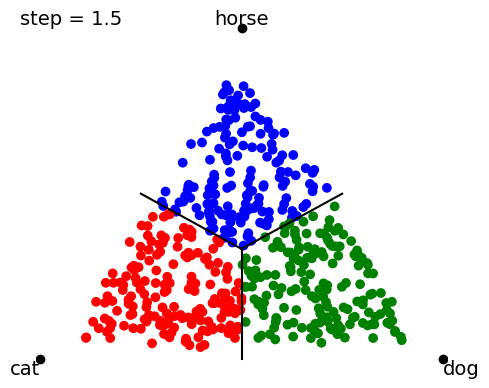

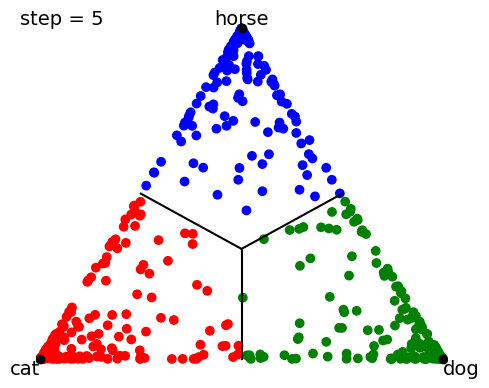

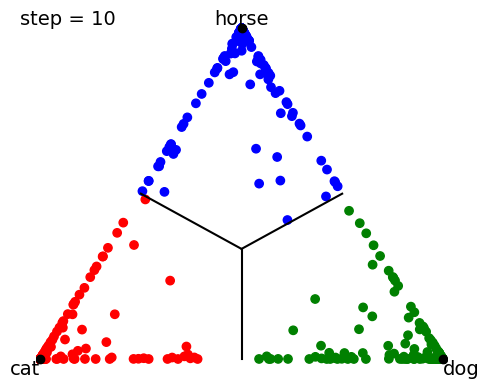

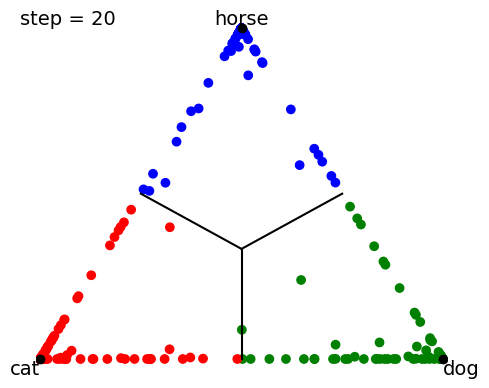

In [ ]:
labels = ['cat','dog','horse']
for s in [1.5,5,10,20]:
    prob, targ = calc_prob(500, s=s)
    myplot = TrianglePlot2D_MPL(prob, targ=targ, labels=labels, show_bounds=True, comment=f'step = {s}').do_plot()

In [ ]:
#| export 

def sorted_eig(A):  # returns sorted eigenvalues (& their corresponding eignevectors) of A
    lambdas, vecs = LA.eig(A)
    # Next line just sorts values & vectors together in order of decreasing eigenvalues
    lambdas, vecs = zip(*sorted(zip(list(lambdas), list(vecs.T)),key=lambda x: x[0], reverse=True))
    return lambdas, np.array(vecs).T  # un-doing the list-casting from the previous line

def pca_proj(data, dim=3):
    """Projects data using Principal Component Analysis"""

    cov = np.cov(data.T)   # get covariance matrix
    lambdas, vecs = sorted_eig(np.array(cov))  # get the eigenvectors
    W = vecs[:,0:dim]                      # Grab the 2 most significant dimensions
    return np.array(data @ W, dtype=np.float32)  # Last step of PCA: projection 

In [ ]:
#| export

plotly_already_setup = False
def setup_plotly(nbdev=True):
    """Plotly is already 'setup' on colab, but on regular Jupyter notebooks we need to do a couple things"""
    global plotly_already_setup 
    if plotly_already_setup: return 
    if nbdev and not on_colab():  # Nick Burrus' code for normal-Juptyer use with plotly & nbdev
        import plotly.io as pio
        pio.renderers.default = 'notebook_connected'
        js = '<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js" integrity="sha512-c3Nl8+7g4LMSTdrm621y7kf9v3SDPnhxLNhcjFJbKECVnmZHTdo+IRO05sNLTH/D3vA6u1X32ehoLC7WFVdheg==" crossorigin="anonymous"></script>'
        display(HTML(js))
    plotly_already_setup = True 


class TrianglePlot3D_Plotly():
    def __init__(self,
        pred,                       # prediction values, probabilities for each class
        targ=None,                  # target values, singly enocde (not one-hot), if none, RGB colors are used
        labels=['x','y','z'],       # class labels
        show_bounds:bool=True,     # show inter-class boundaries or not
        show_labels:bool=True,      # point to class ideal poles with arrows & labels 
        show_axes:bool=True,        # show axes or not
        poles_included=False,       # tells whether the "pole" points / triangle tips are already included in the beginning of preds
        margin_t=0,                 # top margin, plotly's default on Colab is 0, but in jupyter it's 100
        nbdev=True,                 # whether this is for use with nbdev or not; doesn't save full plots in files
        cmap='jet',                 # lots of hate against jet but I love it. the purple->yellow colormaps are hard to read IMHO
        add_poles=True,             # add data points for category ideals
        auto_pca=True,              # if you send it more than 3 dimensions, it will PCA to 3. (note only 10 colors defined)
        **kwargs):
        "plot a 3d triangle plot using plot.ly."
        
        store_attr()
        setup_plotly()

        self.dim, self.odim = pred.shape[-1], pred.shape[-1]   # save original dimension 

        if self.add_poles and not self.poles_included:
            self.poles = np.eye(self.dim)
            self.pred = np.vstack((np.eye(self.dim),self.pred))
            self.targ = None if self.targ is None else np.hstack((np.arange(self.dim),self.targ))
            self.poles_included = True

        if auto_pca and self.dim>3: self.pred, self.dim = pca_proj(self.pred), 3

        clist = ['red','green','blue','orange','purple','black','brown','cyan','pink','yellow']
        self.colors = self.pred if self.targ is None else  [ clist[i] for i in self.targ]
        self.hlabels = None if self.targ is None else [ labels[i] for i in self.targ] # labels for each point

        self.fig = go.Figure(data=[go.Scatter3d(x=self.pred[:,0], y=self.pred[:,1], z=self.pred[:,2], hovertext=self.hlabels,
            mode='markers', marker=dict(size=5, opacity=0.6, color=self.colors))])

    def do_plot(self, pred=None, targ=None, **kwargs):
        self.pred = self.pred if pred is None else pred
        self.targ = self.targ if targ is None else targ 
        assert self.pred is not None, 'Nothing to plot' 

        poles = self.pred[0:self.odim,:] if self.poles_included else np.eye(self.dim)

        if self.show_labels: 
            self.fig.update_layout(scene = dict(
                xaxis_title=f'{self.labels[0]} - ness', yaxis_title=f'{self.labels[1]} - ness', zaxis_title=f'{self.labels[2]} - ness',
                # add little arrows pointing to the "poles" or tips
                annotations = [ dict(text=self.labels[i], xanchor='center', x=poles[i,0], y=poles[i,1], z=poles[i,2]) for i in range(self.odim)]),
                width=700, margin=dict(r=20, b=10, l=10, t=10), showlegend=False
                )
        
        if self.show_bounds and self.odim==3:
            self.fig.add_trace( go.Scatter3d(mode='lines', x=[0.333,0.5], y=[0.333,0.5], z=[0.333,0], 
                line=dict(color='black', width=5) ))
            self.fig.add_trace( go.Scatter3d(mode='lines', x=[0.333,0], y=[0.333,0.5], z=[0.333,0.5], 
                line=dict(color='black', width=5) ))
            self.fig.add_trace( go.Scatter3d(mode='lines', x=[0.333,0.5], y=[0.333,0], z=[0.333,0.5], 
                line=dict(color='black', width=5) ))
            
        if (not self.show_axes) or (self.dim != self.odim):  # turn off the axis names
            self.fig.update_layout(scene=dict(
                xaxis=dict(showticklabels=False, title=''),
                yaxis=dict(showticklabels=False, title=''),
                zaxis=dict(showticklabels=False, title='')))  
                      
        self.fig.update_layout(margin_t=self.margin_t)   
        return self.fig.show()

In [ ]:
prob, targ = calc_prob(n=400)
plot = TrianglePlot3D_Plotly(prob, targ=targ, labels=labels)
plot.do_plot()

In [ ]:
TrianglePlot3D_Plotly(prob, show_bounds=False).do_plot()

In [ ]:
prob4, targ4 = calc_prob(n=500, dim=4)
TrianglePlot3D_Plotly(prob4, targ=targ4, labels=labels+['bird'], show_axes=False).do_plot()

In [ ]:
#| export 

# cat-dog-horse sample image urls (Warning: these may change & stop working; perhaps switch to Imgur)
CDH_SAMPLE_URLS = ['https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Felis_silvestris_catus_lying_on_rice_straw.jpg/220px-Felis_silvestris_catus_lying_on_rice_straw.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/e/e3/Perfect_Side_View_Of_Black_Labrador_North_East_England.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/SilverMorgan.jpg/250px-SilverMorgan.jpg']

bokeh_already_setup = False
def setup_bokeh():
    """bokeh requires we add jquery manually """
    global bokeh_already_setup
    if not bokeh_already_setup:
        js = '<script src="//ajax.googleapis.com/ajax/libs/jquery/1.9.1/jquery.min.js"></script>'
        display(HTML(js))
        bokeh_already_setup = True


class TrianglePlot2D_Bokeh():
    """This gives a 2d plot with image tooltips when the mouse hovers over a data point."""
    # NOTE: in Markdown cells before trying to show the plot, you may need to 
    # force your own JQery import in order for the graph to appear (i.e. if you 
    # get "Uncaught ReferenceError: $ is not defined").  If so, add this:
    # <script src="//ajax.googleapis.com/ajax/libs/jquery/1.9.1/jquery.min.js"></script>

    def __init__(self, 
            pred=None,                  # (n,3): probability values of n data points in each of 3 classes
            targ=None,                  # (n):   target value (0,1,2) for each data point
            labels:list=['0','1','2'],  # the class labels
            show_bounds:bool=True,      # show inter-class boundaries or not
            show_labels:bool=True,      # point to class ideal poles with arrows & labels
            show_axes:bool=True,        # show axes or not
            urls:list=None,             # image urls to display upon mouseover (default: stock images)
            comment:str='',             # just a comment to put in the top left corner
            thumb_height:int=100,       # height of thumbnail images (aspect ratio is preserved)
            ) -> None:                  # __init__ isn't allowed to return anything (it's a Python thing)
        store_attr()
        output_notebook(hide_banner=True)   # output_file("toolbar.html")
        self.colors =  ['red','green','blue']
        self.TOOLTIPS_HTML = f"""
            <div>
                <div>
                    <img
                        src="@imgs" height="{thumb_height}" alt="@imgs" 
                        style="float: left; margin: 0px 15px 15px 0px;"
                        border="2"
                    ></img>
                </div>
                <div>
                    <span style="font-size: 17px; font-weight: bold;">@desc</span>
                    <span style="font-size: 15px; color: #966;">[$index]</span>
                </div>
                <!---commenting-out coordinate values <div>
                    <span style="font-size: 10px; color: #696;">($x, $y)</span>
                </div> -->
            </div>
        """
        setup_bokeh()
        self.clear()
        return 

    def clear(self):
        self.p = figure(plot_width=400, plot_height=350, tooltips=self.TOOLTIPS_HTML, 
            title="Mouse over the dots")
        self.p.toolbar.active_scroll = self.p.select_one(WheelZoomTool)

    def do_plot(self, pred=None, targ=None, urls=None):
        self.pred = self.pred if pred is None else pred
        self.targ = self.targ if targ is None else targ 
        self.urls = self.urls if urls is None else urls
        assert self.pred is not None, 'Nothing to plot' 
        assert self.targ is not None, 'TODO: right now we require targ' 

        xs, ys = self.pred.T[1] - self.pred.T[0], self.pred.T[2]

        if self.show_bounds: 
            self.p.line([0, 0],[0.333,0], line_width=2, color='black')
            self.p.line([0,.5],[0.333,.5], line_width=2, color='black')
            self.p.line([0,-.5],[0.333,.5], line_width=2, color='black')

        n = self.pred.shape[0]
        full_labels = [self.labels[self.targ[i]] for i in range(n)]
        full_colors = [self.colors[self.targ[i]] for i in range(n)]
        full_urls = self.urls if self.urls is not None else [CDH_SAMPLE_URLS[self.targ[i]] for i in range(n)]
        source = ColumnDataSource( data=dict(x=xs, y=ys, desc=full_labels, imgs=full_urls, colors=full_colors ) )
        self.p.circle('x', 'y', size=6, line_color='colors', fill_color='colors', source=source)

        if self.show_labels:
            self.p.add_layout( Label(x=-1, y=0, text=self.labels[0], text_align='right'))
            self.p.add_layout( Label(x=1, y=0, text=self.labels[1]))
            self.p.add_layout( Label(x=0, y=1, text=self.labels[2], text_align='center'))
        
        if self.comment != '':
            self.p.add_layout( Label(x=-1, y=0.95, text=self.comment, text_align='left'))

        return show(self.p)

    def update(self, pred, targ):
        self.pred, self.targ = pred, targ 
        self.clear()
        return self.do_plot()

Testing `TrianglePlot2D_Bokeh`:

*NOTE: Oct 13 2022: DuckDuckGo has made it harder to scrape images, so the image-getting precursor to this test fails.  Will need to update this part later.*

In [ ]:
# DuckDuckGo has made it harder to scrape.  Will need to update this part.
#urls = exhibit_urls(targ, labels)
#bokplot = TrianglePlot2D_Bokeh(prob, targ=targ, labels=labels, comment='2D Bokeh', urls=urls)
#bokplot.do_plot()

## FastAI Callback:

In [ ]:
#| export 
class VizPreds(Callback):
    "Progress-like callback: call the bokeh triangle plot with each batch of training"
    order = ProgressCallback.order+1
    def __init__(self, 
        method='auto',   # plotting method must have a .do_plot(preds,targs)
        gen_urls=True,   # if we should generate thumbnail urls (if they don't exist) (2D_Bokeh only)
        thumb_height=80, # lets you vary the height of image thumbnails (2D_Bokeh only)
        force_new_urls=False, # if False, keeps whatever thumbnail urls are in learn.dls
    ): 
        store_attr()
        self.we_made_the_thumbs = False  # so that we don't force-gen new urls a 2nd time after un-freezing

    def before_fit(self):
        if self.method=='auto':
            self.method = TrianglePlot2D_Bokeh if len(self.learn.dls.vocab) <= 3 else TrianglePlot3D_Plotly

        dv = self.learn.dls.valid       # just a shorthand
        if self.gen_urls and self.method==TrianglePlot2D_Bokeh and (('url_dict' not in dir(dv)) or self.force_new_urls) and not self.we_made_the_thumbs:
            self.we_made_the_thumbs = True
            self.learn.dls.valid.url_dict = dict(zip(dv.items, get_thumb_urls(dv.items, size=(self.thumb_height,self.thumb_height)))) 
 
    def before_epoch(self):
        if not self.learn.training:
            self.learn.viz_preds, self.learn.viz_targs = None, None

    def after_batch(self, **kwargs): 
        if not self.learn.training:
            with torch.no_grad():  
                preds, targs = F.softmax(self.learn.pred, dim=1), self.learn.y # pred is logits
                preds, targs = [x.detach().cpu().numpy().copy() for x in [preds,targs]] 
                self.learn.viz_preds = preds if self.learn.viz_preds is None else np.vstack((self.learn.viz_preds, preds))
                self.learn.viz_targs = targs if self.learn.viz_targs is None else np.hstack((self.learn.viz_targs, targs))

    def after_epoch(self):
        if not self.learn.training:
            print(f"Epoch {self.learn.epoch}: Plotting {len(self.learn.viz_targs)} (= {len(self.learn.dls.valid.items)}?) points:")
            urls = None
            if self.method==TrianglePlot2D_Bokeh:
                dv = self.learn.dls.valid       # just a shorthand
                urls = [dv.url_dict[f] for f in dv.items] if 'url_dict' in dir(dv) else dv.items
            self.method(self.learn.viz_preds, self.learn.viz_targs, urls=urls, labels=self.dls.vocab, 
                comment=f'Epoch {self.learn.epoch}', thumb_height=self.thumb_height).do_plot()

## Made this for a talk, just talking about probabilities:

In [ ]:
#| export 
def image_and_bars(values, labels, image_url, title="Probabilities", height=225, width=500):
    """Plot an image along with a bar graph"""
    fig = go.Figure()
    fig.add_trace( go.Bar(x=labels, y=values, marker_color=["red","green","blue"]) )
    fig.add_layout_image(
        dict(
            source=image_url,
            xref="paper", yref="paper",
            x=-0.2, y=0.5,
            sizex=1, sizey=1,
            xanchor="right", yanchor="middle"
        )
    )
        # update layout properties
    fig.update_layout(
        autosize=False,
        height=height, width=width,
        bargap=0.15,
        bargroupgap=0.1,
        barmode="stack",
        hovermode="x",
        margin=dict(r=20, l=width*0.55, t=30, b=20),
        yaxis=dict(range=[0,1]),
        title={
        'text': title,
        'y':0.9,
        'x':0.76,
        'xanchor': 'center',
        'yanchor': 'bottom'}
    )
    return fig 

In [ ]:
data = np.array([[0.7,0.2,0.1],[0.15,0.6,0.25],[0.05,0.15,0.8]])
for i in range(3):
    image_and_bars(data[i], labels, CDH_SAMPLE_URLS[i]).show(config = {'displayModeBar': False})
    print("")